# Multifactorial ANOVA
## 2 factors, crossed design
Reference: http://www.flutterbys.com.au/stats/tut/tut7.6b.html

In [1]:
import pandas as pd
import numpy as np
 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import pymc3 as pm
import patsy

C:\Miniconda3\envs\GLM_with_PyMC3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Data generation

In [2]:
nA = 2  #number of levels of A
nB = 3  #number of levels of B

nsample = 10  #number of reps in each

labelsA = ['a{}'.format(i) for i in range(nA)]
labelsB = ['b{}'.format(i) for i in range(nB)]

A = np.repeat(labelsA, repeats=[nsample//nA, nsample//nA + nsample%nA])
B = np.repeat(labelsB, repeats=[nsample//nB, nsample//nB, nsample//nB + nsample%nB])

In [3]:
# cartesian product
import itertools
data = pd.DataFrame([row for row in itertools.product(labelsA, labelsB, np.arange(nsample)+1)], columns=['A', 'B', 'n'])
data.head()

,A,B,n
0,a0,b0,1
1,a0,b0,2
2,a0,b0,3
3,a0,b0,4
4,a0,b0,5


In [4]:
# Whilst the above two are equivalent for simple designs 
# (such as that illustrated), the means parameterization 
# (that does not include an intercept, or overall mean) 
# is limited to simple single factor designs. 
# Designs that involve additional predictors can only be
# accommodated via effects parameterization.

X_design = patsy.dmatrix("1 + A*B", data=data, return_type='dataframe')

X = np.asarray(X_design)
X_design.head()

,Intercept,A[T.a1],B[T.b1],B[T.b2],A[T.a1]:B[T.b1],A[T.a1]:B[T.b2]
0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0


In [17]:
np.random.seed(12345)

eff = np.array([40, 15, 5, 0, -15, 10])
sigma = 0  #residual standard deviation
eps = np.random.normal(loc=0, scale=sigma, size=X.shape[0])

y = np.dot(X, eff) + eps
data['y'] = y
data['A'] = pd.Categorical(data.A, ordered=False)
data['B'] = pd.Categorical(data.B, ordered=False)
data.head

<bound method NDFrame.head of      A   B   n     y
0   a0  b0   1  40.0
1   a0  b0   2  40.0
2   a0  b0   3  40.0
3   a0  b0   4  40.0
4   a0  b0   5  40.0
5   a0  b0   6  40.0
6   a0  b0   7  40.0
7   a0  b0   8  40.0
8   a0  b0   9  40.0
9   a0  b0  10  40.0
10  a0  b1   1  45.0
11  a0  b1   2  45.0
12  a0  b1   3  45.0
13  a0  b1   4  45.0
14  a0  b1   5  45.0
15  a0  b1   6  45.0
16  a0  b1   7  45.0
17  a0  b1   8  45.0
18  a0  b1   9  45.0
19  a0  b1  10  45.0
20  a0  b2   1  40.0
21  a0  b2   2  40.0
22  a0  b2   3  40.0
23  a0  b2   4  40.0
24  a0  b2   5  40.0
25  a0  b2   6  40.0
26  a0  b2   7  40.0
27  a0  b2   8  40.0
28  a0  b2   9  40.0
29  a0  b2  10  40.0
30  a1  b0   1  55.0
31  a1  b0   2  55.0
32  a1  b0   3  55.0
33  a1  b0   4  55.0
34  a1  b0   5  55.0
35  a1  b0   6  55.0
36  a1  b0   7  55.0
37  a1  b0   8  55.0
38  a1  b0   9  55.0
39  a1  b0  10  55.0
40  a1  b1   1  45.0
41  a1  b1   2  45.0
42  a1  b1   3  45.0
43  a1  b1   4  45.0
44  a1  b1   5  45.0
45  

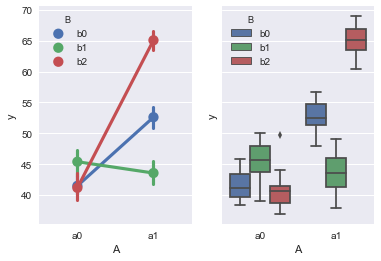

In [6]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
_ = sns.pointplot(x='A', y='y', hue='B', data=data, ax=ax[0])
_ = sns.boxplot(x='A', y='y', hue='B', data=data, ax=ax[1])

The data seems to be close to the one used in http://www.flutterbys.com.au/stats/tut/tut7.6b.html

### Bayesian modelling (Multifactorial ANOVA)
Assumption: The response variable is equally varied for each combination of treatments. (In fact, it is as we generated the data)

In [7]:
with pm.Model() as ANOVA_factorial_treatment_coding:
    
    beta = pm.Normal('beta', mu=0, sd=100, shape=(X.shape[1]))
    sd = pm.HalfCauchy('sd', beta=5)
    
    mu = pm.math.dot(X, beta)
    
    # assume same sd. How to index different sd's distributions?
    y_likelihood = pm.Normal('y_likelihood', mu=mu, sd=sd, observed=data.y)
    
    trace = pm.sample(draws=1500, step=pm.NUTS(), njobs=2, tune=500)

C:\Miniconda3\envs\GLM_with_PyMC3\lib\site-packages\pymc3\model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd_log__, beta]


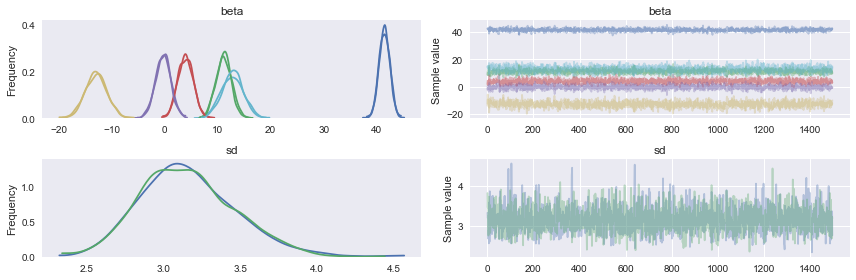

In [8]:
_ = pm.traceplot(trace)

In [9]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta__0,41.488535,1.018161,0.028802,39.566701,43.489019,1081.0,0.999902
beta__1,11.128384,1.446640,0.043289,8.327320,13.913802,1037.0,1.000671
beta__2,3.908116,1.449137,0.039285,1.248053,6.857022,1175.0,0.999703
beta__3,-0.327387,1.434455,0.039983,-3.150595,2.535341,1244.0,0.999863
beta__4,-12.978722,2.036750,0.054264,-16.810927,-8.944352,1174.0,1.000231
beta__5,12.772143,2.024029,0.058940,8.820077,16.631536,1167.0,1.000311
sd,3.157951,0.309123,0.005946,2.598659,3.776146,2457.0,0.999728


In [10]:
df_for_display = pm.summary(trace)

rows_name = X_design.design_info.column_names[:]
rows_name.append('sd')

df_for_display.index = rows_name
df_for_display

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Intercept,41.488535,1.018161,0.028802,39.566701,43.489019,1081.0,0.999902
A[T.a1],11.128384,1.446640,0.043289,8.327320,13.913802,1037.0,1.000671
B[T.b1],3.908116,1.449137,0.039285,1.248053,6.857022,1175.0,0.999703
B[T.b2],-0.327387,1.434455,0.039983,-3.150595,2.535341,1244.0,0.999863
A[T.a1]:B[T.b1],-12.978722,2.036750,0.054264,-16.810927,-8.944352,1174.0,1.000231
A[T.a1]:B[T.b2],12.772143,2.024029,0.058940,8.820077,16.631536,1167.0,1.000311
sd,3.157951,0.309123,0.005946,2.598659,3.776146,2457.0,0.999728


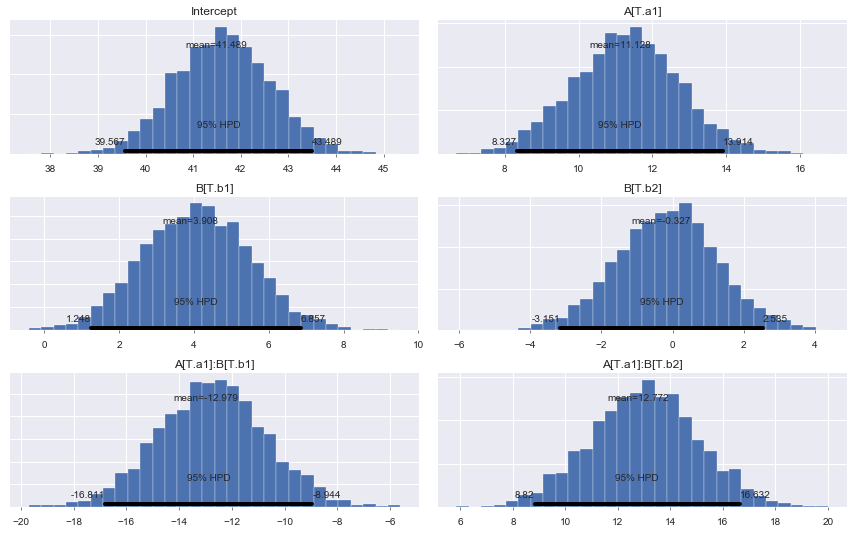

In [11]:
X_design.design_info.column_names
ax = pm.plot_posterior(trace, ['beta'])
for idx, title in enumerate(X_design.design_info.column_names):
    ax[idx].set_title(title)

Let's try to run an ANOVA relaxing the assumption that the variance is equally distributed. 

In [12]:
with pm.Model() as ANOVA_factorial_treatment_coding_sd:
    
    beta = pm.Normal('beta', mu=0, sd=100, shape=(X.shape[1]))
    sd = pm.HalfCauchy('sd', beta=5, shape=(nA, nB))
    
    mu = pm.math.dot(X, beta)
    
    # assume same sd. How to index different sd's distributions?
    y_likelihood = pm.Normal('y_likelihood', mu=mu, sd=sd[data.A.cat.codes, data.B.cat.codes], observed=data.y)
    
    trace = pm.sample(draws=3000, step=pm.NUTS(), njobs=2, tune=1000)

C:\Miniconda3\envs\GLM_with_PyMC3\lib\site-packages\pymc3\model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd_log__, beta]


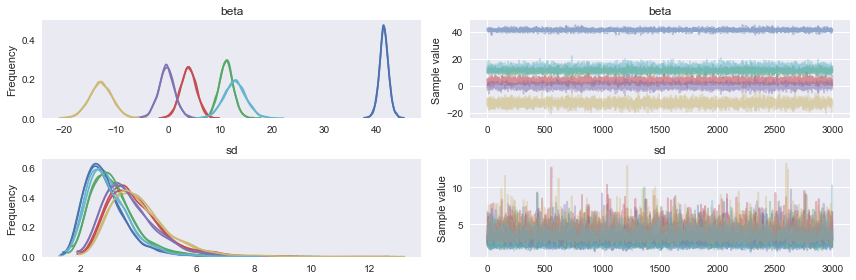

In [13]:
_ = pm.traceplot(trace)

In [14]:
nA*nB

6